<a href="https://colab.research.google.com/github/jsebastianquiroga/Topicos_analitica/blob/main/Notebook/Empirical_network_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img style="float: center; padding-right: 10px;" src="https://www.pikpng.com/pngl/b/467-4670553_universidad-javeriana-esslingen-am-neckar-clipart.png" width="100" height="150">



<h1> <strong>Tópicos avanzados en analítica.</strong></h1> 
<h2> Para: Luis Gabriel Moreno Sandoval.</br></h2>
<h2>Integrantes:</br></h2>
<h2>Alejandro Vivas.</br></h2>
<h2>Johan Sebastian Muñoz.</br></h2>
<h2>Juan Sebastián Quiroga Bernal. </h2>

<h1> <strong>Workshop 1: Empirical Network  - Twitter.</strong></h1> 

En el presnte Notebook, se desarrollar una funcion que permita extraer los tuits que se desen con la API de snscrape.


Este docuemnto esta dividio en las siguientes partes:
<ol>
Parte 1
<ol>
    <li>Grafo de Retweets</li>
    <li>Grafo de Hashtags</li>
</ol>

Parte 2
<ol>
    <li>Creación de grafico que asocie las palabras mas usadas</li>
    <li>Grafo de usuarios y emojis</li>
</ol>


Conclusiones.</li>
</ol>

***

# <h1><strong> 1.1 Grafo de Retweets: </h1></strong>

Para la primera parte de este taller, se hizo la definición de varias funciones que servirán para: </br>

<ol>
<li> Consulta (query): Es el valor que se desea buscar en el df.</li>
<li> Método de Consulta (search_method): Este parámetro funciona para seleccionar el método de consulta que se quiere hacer al df que descargamos de los twitts, un ejemplo es 'username', lo que hará esto es buscar en la variable de username el valor que se está buscando. </li>
<li> Numero de Tweets (max_tweets): El número de tweets que se van a extraer de Twitter el valor que se desea buscar en el df.</li>
<li> Fecha de Inicio Búsqueda (start_date): Se especifica una fecha específica de inicio en la búsqueda de información. </li>
<li> Fecha de Fin búsqueda (end_date): Se especifica una fecha específica de fin en la búsqueda de información. </li>
</ol>

Esto permite que las búsquedas se hagan de una manera mucho más dinámica y efectiva.


In [ ]:
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import snscrape.modules.twitter as sntwitter
import networkx as nx
import plotly.graph_objects as go
import re
import pandas as pd

import snscrape.modules.twitter as sntwitter
import networkx as nx
import plotly.graph_objects as go
import re
import pandas as pd
import plotly.express as px
import datetime as dt
import pytz

class TwitterGraph:
    def __init__(self, query, search_method, max_tweets=100, start_date=None, end_date=None):
        self.query = query
        self.search_method = search_method
        self.max_tweets = max_tweets
        self.start_date = start_date
        self.end_date = end_date
        self.graph = nx.Graph()
        self.data = None


    def _create_scraper(self):
        # construct search query based on search method and time range filters
        if self.start_date and self.end_date:
            date_range_query = f'since:{self.start_date} until:{self.end_date}'
            search_query = f'{self.query} {date_range_query}'
        else:
            search_query = self.query

        # remove '@' symbol from the query if the search_method is 'username'
        if self.search_method == 'username':
            search_query = search_query.strip('@')

        # create a scraper object based on the search method
        if self.search_method == 'keyword':
            scraper = sntwitter.TwitterSearchScraper(search_query)
        elif self.search_method == 'hashtag':
            scraper = sntwitter.TwitterSearchScraper(f'#{search_query}')
        elif self.search_method == 'username':
            scraper = sntwitter.TwitterSearchScraper(f'from:{search_query}')
        elif self.search_method == 'list':
            scraper = sntwitter.TwitterListScraper(search_query)
        elif self.search_method == 'advanced':
            scraper = sntwitter.TwitterSearchScraper(search_query)
        elif self.search_method == 'location':
            scraper = sntwitter.TwitterSearchScraper(search_query)
        else:
            raise ValueError("Invalid search_method. Must be 'keyword', 'hashtag', 'username', 'list', 'advanced', or 'location'.")

        return scraper

    def _scrape_tweets(self):
        scraper = self._create_scraper()
        
        tweets = []
        count = 0
        # fetch tweets until we reach the desired number of tweets
        for tweet in scraper.get_items():
            if count >= self.max_tweets:
                break
            tweets.append(tweet)
            count += 1

        # filter tweets by date range if start_date and end_date are specified
        if self.start_date and self.end_date:
            start_date_dt = dt.datetime.strptime(self.start_date, '%Y-%m-%d').replace(tzinfo=pytz.UTC)
            end_date_dt = dt.datetime.strptime(self.end_date, '%Y-%m-%d').replace(tzinfo=pytz.UTC)
            filtered_tweets = []
            for tweet in tweets:
                if tweet.date >= start_date_dt and tweet.date <= end_date_dt:
                    filtered_tweets.append(tweet)
            tweets = filtered_tweets

        # extract tweet information
        data = []
        for tweet in tweets:
            # extract hashtags
            hashtags = re.findall(r'#\w+', tweet.rawContent)

            # modify graph edges depending on search_method
            if self.search_method == 'hashtag':
                for i, h1 in enumerate(hashtags):
                    for h2 in hashtags[i+1:]:
                        # create an edge between hashtags
                        self.graph.add_edge(h1, h2)
            elif self.search_method == 'username':
                for i, h1 in enumerate(hashtags):
                    # create an edge between user and hashtag
                    self.graph.add_edge(tweet.user.username, h1)
            else:
                for i, h1 in enumerate(hashtags):
                    for h2 in hashtags[i+1:]:
                        # create an edge between users who have used the same hashtag
                        self.graph.add_edge(tweet.user.username, h1)
                        self.graph.add_edge(tweet.user.username, h2)

            # add edges for user mentions and retweets
            mentioned_users = [user.username for user in tweet.mentionedUsers] if tweet.mentionedUsers else []
            for user in mentioned_users:
                self.graph.add_edge(tweet.user.username, user)
            if tweet.retweetedTweet:
                self.graph.add_edge(tweet.user.username, tweet.retweetedTweet.user.username)

            
            data.append({
                'tweet_id': tweet.id,
                'username': tweet.user.username,
                'Replay_to':tweet.inReplyToUser,
                'user_mentioned': tweet.mentionedUsers,
                'retweet' : tweet.retweetedTweet,
                'quoted_tweet' : tweet.quotedTweet,
                'content': tweet.rawContent,
                'date': tweet.date,
                'retweets': tweet.retweetCount,
                'likes': tweet.likeCount,
                'quotes': tweet.quoteCount,
                'replies': tweet.replyCount,
                'url': tweet.url,
                'place': tweet.place,
                'hashtags': tweet.hashtags,
                'cashtags' : tweet.cashtags
            })

        # Create a DataFrame from the extracted data
        self.data = pd.DataFrame(data)
        return data

    def build_graph(self):
        self._scrape_tweets()
        self.graph.remove_nodes_from(list(nx.isolates(self.graph)))

        # compute node positions for the graph
        node_positions = nx.spring_layout(self.graph)

        # create a dictionary that maps usernames to node positions
        user_positions = {}
        for node, pos in node_positions.items():
            user_positions[node] = pos
            self.graph.nodes[node]['pos'] = pos

        return user_positions
        
    def visualize_graph(self):
        # get the node positions from the built graph
        node_positions = self.build_graph()

        # create a dataframe from the node positions
        pos_df = pd.DataFrame(node_positions, index=['x', 'y']).T
        pos_df.index.name = 'node'

        # add the node positions to the graph
        nx.set_node_attributes(self.graph, pos_df.to_dict('index'))

        # create a plotly figure object
        fig = px.scatter(pos_df, x='x', y='y', text=pos_df.index, custom_data=[pos_df.index])

        # add edges to the figure
        for edge in self.graph.edges:
            x0, y0 = self.graph.nodes[edge[0]]['x'], self.graph.nodes[edge[0]]['y']
            x1, y1 = self.graph.nodes[edge[1]]['x'], self.graph.nodes[edge[1]]['y']
            fig.add_trace(
                go.Scatter(x=[x0, x1], y=[y0, y1], mode='lines', line=dict(color='gray'))
            )

        # configure the figure layout
        fig.update_traces(textposition='top center', marker=dict(size=10, color='lightblue'), hovertemplate='Username: %{customdata[0]}<extra></extra>')
        fig.update_layout(title=f'Twitter Graph for {self.query}', title_font_size=30,
                          xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                          yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                          hovermode='closest')

        # display the figure
        fig.show()

In [ ]:
tg = TwitterGraph(query = '@HasbullaHive', search_method = 'username', max_tweets = 200)#,  start_date = '2020-01-01', end_date = '2020-02-01')
tg.visualize_graph()

In [ ]:
tg.data

,tweet_id,username,Replay_to,user_mentioned,retweet,quoted_tweet,content,date,retweets,likes,quotes,replies,url,place,hashtags,cashtags
0,1637150687909015554,HasbullaHive,None,[https://twitter.com/elonmusk],None,None,Plot Twist\n\n@elonmusk was in the costume htt...,2023-03-18 17:55:15+00:00,982,13244,161,135,https://twitter.com/HasbullaHive/status/163715...,None,None,None
1,1637110985004810242,HasbullaHive,https://twitter.com/HasbullaHive,None,None,None,Can’t believe we didn’t get a Hasbulla LeBron ...,2023-03-18 15:17:29+00:00,7,429,2,6,https://twitter.com/HasbullaHive/status/163711...,None,None,None
2,1636966987120398336,HasbullaHive,None,None,None,None,Lakers needed Hasbulla in the lineup https://...,2023-03-18 05:45:17+00:00,3154,43887,189,146,https://twitter.com/HasbullaHive/status/163696...,None,None,None
3,1636948847183409153,HasbullaHive,https://twitter.com/HasbullaHive,None,None,None,The stars are out in LA ⭐️ https://t.co/TL77zJ...,2023-03-18 04:33:12+00:00,1686,21742,73,56,https://twitter.com/HasbullaHive/status/163694...,None,None,None
4,1636948584292827136,HasbullaHive,https://twitter.com/bansky,[https://twitter.com/bansky],None,None,@bansky facts,2023-03-18 04:32:10+00:00,2,133,0,5,https://twitter.com/HasbullaHive/status/163694...,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1623323950653784066,HasbullaHive,https://twitter.com/MDquazz,[https://twitter.com/MDquazz],None,None,@MDquazz We were required to put fan page when...,2023-02-08 14:12:44+00:00,0,3,0,1,https://twitter.com/HasbullaHive/status/162332...,None,None,None
196,1623321501507407873,HasbullaHive,https://twitter.com/HasbullaHive,None,None,https://twitter.com/HasbullaHive/status/161778...,Get some while you still can,2023-02-08 14:03:00+00:00,8,386,1,8,https://twitter.com/HasbullaHive/status/162332...,None,None,None
197,1623207875228364800,HasbullaHive,https://twitter.com/martzpad,[https://twitter.com/martzpad],None,None,@martzpad 10/10,2023-02-08 06:31:29+00:00,10,3516,0,7,https://twitter.com/HasbullaHive/status/162320...,None,None,None
198,1623165423163437056,HasbullaHive,https://twitter.com/TanuGutierrez1,[https://twitter.com/TanuGutierrez1],None,None,@TanuGutierrez1 8/10,2023-02-08 03:42:48+00:00,6,1213,1,4,https://twitter.com/HasbullaHive/status/162316...,None,None,None


# **Conclusion 1.1:**</br>
Para el análisis de retweets, se utilizó el método de búsqueda 'username', se buscó el perfil '@HasbullaHive', se extrajeron 200 tweets y analizamos cuales fueron los retweets que se hicieron desde esta cuenta, dentro de los perfiles interesante encontramos el de elon musk


# <h1><strong> 1.2 Grafo de Hashtags: </h1></strong>

In [ ]:
tg1 = TwitterGraph(query = '#Hasbulla', search_method = 'hashtag', max_tweets = 100)#,  start_date = '2020-01-01', end_date = '2020-02-01')
tg1.visualize_graph()

In [ ]:
tg1.data

,tweet_id,username,Replay_to,user_mentioned,retweet,quoted_tweet,content,date,retweets,likes,quotes,replies,url,place,hashtags,cashtags
0,1637167866209247232,andreastoolbox,None,None,None,None,"NBA, Hasbulla Magomedov in prima fila: il re d...",2023-03-18 19:03:31+00:00,0,0,0,0,https://twitter.com/andreastoolbox/status/1637...,None,"[Hasbulla, NBA, Magomedov, prima, in]",None
1,1637155236946104321,Sthephano13,None,None,None,None,My boy! #Russia #hasbulla #luka https://t.co/y...,2023-03-18 18:13:20+00:00,0,0,0,0,https://twitter.com/Sthephano13/status/1637155...,None,"[Russia, hasbulla, luka]",None
2,1637148909075304448,faulkpace99,None,None,None,None,What a game last night… highlight was when #ha...,2023-03-18 17:48:11+00:00,0,0,0,0,https://twitter.com/faulkpace99/status/1637148...,None,"[hasbulla, lakers]",None
3,1637145851347836930,Deportrece,None,None,None,None,Te dejamos un Hasbulla con Luka Doncic para qu...,2023-03-18 17:36:02+00:00,2,2,0,0,https://twitter.com/Deportrece/status/16371458...,None,"[NBA, LukaDoncic, Hasbulla]",None
4,1637142954337869824,NoCapxGaming,None,None,None,None,#youtube Hasbulla Golden Desert Eagle Green Sc...,2023-03-18 17:24:31+00:00,0,1,0,0,https://twitter.com/NoCapxGaming/status/163714...,None,"[youtube, hasbulla, meme, gold]",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1635447225114296321,brittan_duncan,https://twitter.com/adinross,"[https://twitter.com/adinross, https://twitter...",None,None,@adinross @HasbullaHive #hasbulla ❤️,2023-03-14 01:06:18+00:00,0,0,0,0,https://twitter.com/brittan_duncan/status/1635...,None,[hasbulla],None
96,1635443836724948994,david_floresss,None,[https://twitter.com/HasbullaHive],None,None,Una foto con 🤣🤣🤣 @HasbullaHive #hasbulla https...,2023-03-14 00:52:50+00:00,0,1,0,0,https://twitter.com/david_floresss/status/1635...,None,[hasbulla],None
97,1635443232669614081,JetsRalphy,https://twitter.com/iamSauceGardner,[https://twitter.com/iamSauceGardner],None,None,@iamSauceGardner #Hasbulla #Jets #TakeFlight ✈...,2023-03-14 00:50:26+00:00,1,45,0,0,https://twitter.com/JetsRalphy/status/16354432...,None,"[Hasbulla, Jets, TakeFlight]",None
98,1635430913772515329,_CryptoBigfoot,https://twitter.com/Lytsout193,"[https://twitter.com/Lytsout193, https://twitt...",None,None,"@Lytsout193 Whenever I'm down, I watch stand-u...",2023-03-14 00:01:29+00:00,0,2,0,0,https://twitter.com/_CryptoBigfoot/status/1635...,None,[Hasbulla],None


# **Conclusion 1.2:**</br>
Para el analisis de hashtags, se utilizo el metodo de busqueda 'hashtag', se buscó el perfil '#Hasbulla', se extrajeron 100 tweets y analizamos cuales fueron los hashtags que se encuentran acompañados con el hashtag que colocamos en la busqueda y luego cuales repiten entre los diferentes usuarios.

# <h1><strong> 2.1 Creación de grafico que asocie las palabras mas usadas: </h1></strong>

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning:

Glyph 78069 (\N{EGYPTIAN HIEROGLYPH E030}) missing from current font.

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning:

Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning:

Matplotlib currently does not support Devanagari natively.

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning:

Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.



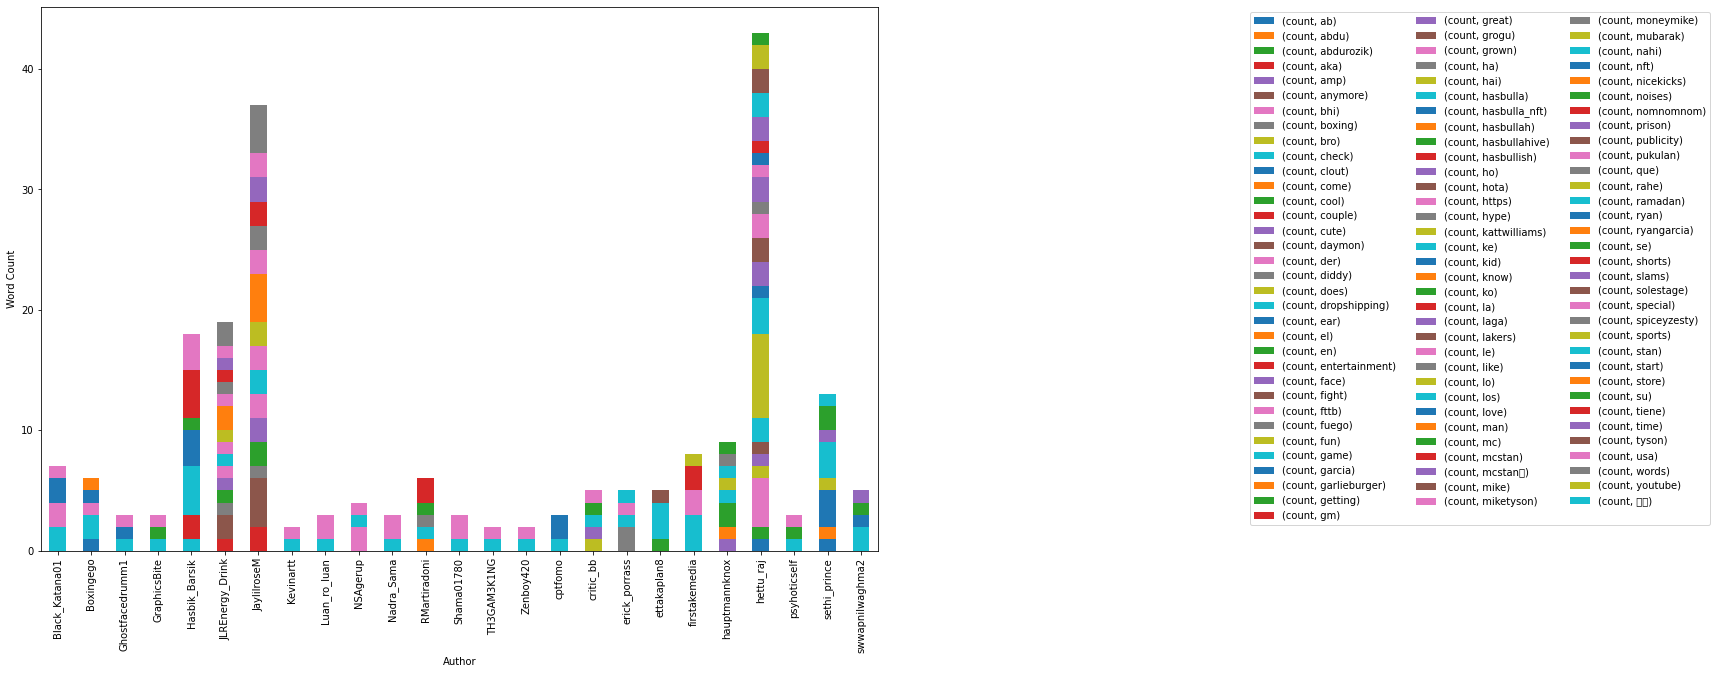

In [104]:
import matplotlib.pyplot as plt


# Creamos un df con la informacion del punto 1.2

df_palabras=pd.DataFrame(tg1.data)

vectorizer = CountVectorizer(stop_words='english', max_features=100)
vectorizer.fit(df_palabras['content'])

# Creamos un directorio para guardar lo que se necesite para cada usuario
user_dtm_dict = {}

# Ciclo que orfaniza la informacion de los tweets y la coloca en un mejor formato
for user in df_palabras['username'].unique():
    user_texts = df_palabras.loc[df_palabras['username'] == user, 'content']
    user_dtm = vectorizer.transform(user_texts)
    user_dtm_df = pd.DataFrame(user_dtm.toarray(), columns=vectorizer.get_feature_names_out())
    user_dtm_dict[user] = user_dtm_df

top_words = user_dtm_dict['Kevinartt'].sum().sort_values(ascending=False)[:100]
user_word_counts = {}
for word in top_words.index:
    user_word_counts[word] = {}
    for user, user_dtm_df in user_dtm_dict.items():
        count = user_dtm_df[word].sum()
        user_word_counts[word][user] = count


author_word_counts_df = pd.DataFrame.from_dict(user_word_counts)

# Grafico de barras que muestra cuantas veces repiten la misma palabra los usauarios
df = author_word_counts_df.head(25)
df.reset_index(inplace=True)
df.rename(columns = {'index':'hola'})
df1 = df.melt(id_vars = 'index', var_name = 'word', value_name = 'count')

fig, ax = plt.subplots()
df1.groupby(['index','word']).sum().unstack().plot.bar(stacked=True,figsize=(15,10),ax=ax)
plt.legend(loc='upper right', bbox_to_anchor=(0,0,2,1),ncol=3)
ax.set_xlabel('Author')
ax.set_ylabel('Word Count')
plt.show()

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning:

Glyph 78069 (\N{EGYPTIAN HIEROGLYPH E030}) missing from current font.

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning:

Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning:

Matplotlib currently does not support Devanagari natively.

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning:

Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.



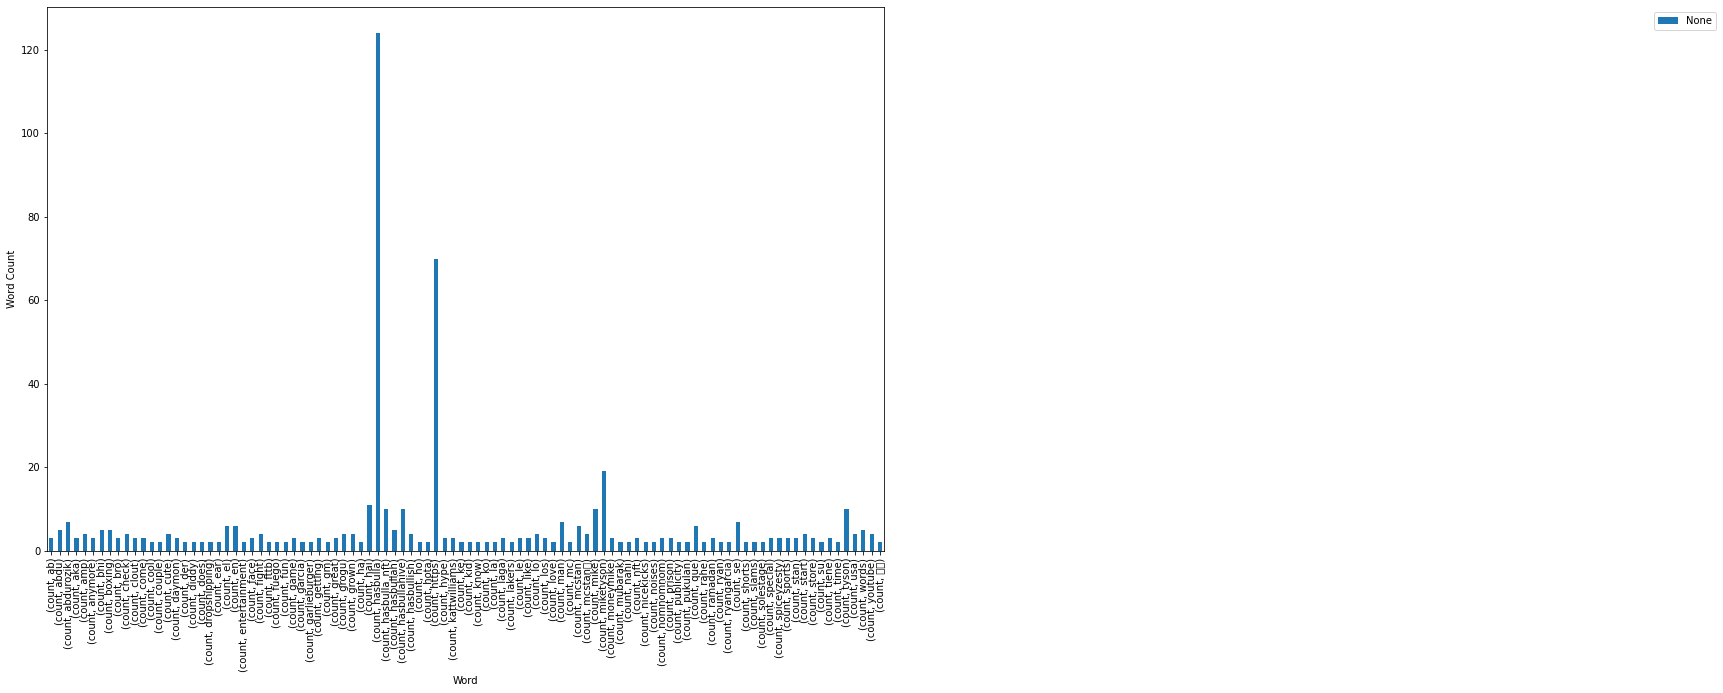

In [106]:
# Grafico de cantidad de veces que aparecio una palabra

df = author_word_counts_df.copy()
df.reset_index(inplace=True)
df.rename(columns = {'index':'hola'})
df1 = df.melt(id_vars = 'index', var_name = 'word', value_name = 'count')

fig, ax = plt.subplots()
df1.groupby(['word']).sum().unstack().plot.bar(stacked=True,figsize=(15,10),ax=ax)
plt.legend(loc='upper right', bbox_to_anchor=(0,0,2,1),ncol=3)
ax.set_xlabel('Word')
ax.set_ylabel('Word Count')
plt.show()

# **Conclusion 2.1:**</br>

Para el analisis de las 100 palabras mas utilizadas, utilizamos los mismos resultados del punto 1.2, los hallazgos principales son que la palabra que mas aparece para el tema en cuestion es 'hasbulla', lo cual tiene mucho sentido por la consulta que se utilizo. Debido a la cantidad de usuarios que hicieron uso del hashtag, es complicado verlos a todos en la misma imagen, es por esto que es necesario definir en el codigo la cantidad de usuarios que deseamos ver.

# <h1><strong> 2.2 Grafo de usuarios y emojis: </h1></strong>

In [ ]:
## Hola